# USGS 3DEP LiDAR Data Tutorial

This is a tutorial developed to teach you how to use the USGS 3DEP LiDAR data published in AWS Open Data program (https://registry.opendata.aws/usgs-lidar/). 

## Install Miniconda

Follow the instructions on https://www.anaconda.com/docs/getting-started/miniconda/install

## Create a virtual environment

```bash
$ conda create -n usgs3dep 
$ conda activate usgs3dep
```

## Install required module

```bash
$ conda install -c conda-forge mamba
$ mamba install -c conda-forge python-pdal gdal entwine matplotlib leafmap laspy jupyter progressbar xarray00
$ pip install "d2spy[geo]"
$ pip install localtileserver
```

Once all modules are installed, then we need to start a Jupyter Notebook

```bash
$ jupyter notebook
```

In [1]:
import leafmap
from shapely.geometry import box
from pystac_client import Client
import geopandas as gpd
import pdal
import json
import math
import os
from d2spy.extras.utils import clip_by_mask

In [2]:
def calculate_utm_zone(longitude):
    """
    Calculates the UTM zone number based on longitude.
    """
    # UTM zones start at 180° W (longitude -180) and increase eastward.
    # Each zone is 6 degrees wide.
    # Adding 180 aligns the 0-point of the calculation with -180 longitude.
    # Dividing by 6 determines the 6-degree block.
    # Adding 1 accounts for 1-based indexing of UTM zones.
    return int(math.floor((longitude + 180) / 6)) + 1

## Setting an Area of Interest (AOI)

In [3]:
m = leafmap.Map(center=[40.4259, -86.9081], zoom=16)
m

Map(center=[40.4259, -86.9081], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [4]:
bbox = m.user_roi_bounds()
bbox

[-86.925, 40.4599, -86.9149, 40.4642]

## Finding a STAC Collection over the AOI.

In [5]:
client = Client.open("https://stac-api.d2s.org")
search = client.search(max_items=10, collections=["3dep"], bbox=bbox)
stac_browser_base_item_url = "https://stac.d2s.org/collections/3dep/items"
items = []
index = 0
for item in search.items():
    items.append(item)
    print(f"index: {index}")
    print(f"ID: {item.id}")
    print(f"STAC Browser URL: {stac_browser_base_item_url}/{item.id}")
    print(f"Entwine URL: {item.assets['ept.json'].href}")
    print("")
    index += 1

index: 0
ID: USGS_LPC_IN_WT_B10_Tippecanoe_2013_LAS_2016
STAC Browser URL: https://stac.d2s.org/collections/3dep/items/USGS_LPC_IN_WT_B10_Tippecanoe_2013_LAS_2016
Entwine URL: https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_IN_WT_B10_Tippecanoe_2013_LAS_2016/ept.json

index: 1
ID: IN_Statewide_Opt2_B2_2017
STAC Browser URL: https://stac.d2s.org/collections/3dep/items/IN_Statewide_Opt2_B2_2017
Entwine URL: https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IN_Statewide_Opt2_B2_2017/ept.json



In [6]:
# Pick an item from the query results.
lidar_item = items[1]

## Downloading the clipped 3DEP data

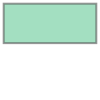

In [7]:
# Grab min, max of x and y
minx = bbox[0]
miny = bbox[1]
maxx = bbox[2]
maxy = bbox[3]

bbox_poly = box(minx, miny, maxx, maxy)

bbox_poly

In [8]:
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_poly], crs="EPSG:4326")
print(bbox_gdf)

   0                                           geometry
0  1  POLYGON ((-86.9149 40.4599, -86.9149 40.4642, ...


USGS 3DEP data on AWS Open Data Program are in Spherical Meractor CRS (EPSG:3857)

In [9]:
entwine_epsg = "EPSG:3857"
new_poly = bbox_gdf.to_crs(entwine_epsg)
new_bounding_box = new_poly.total_bounds.tolist()
new_bounding_box

[-9676446.737205304, 4933000.497049607, -9675322.410348292, 4933629.638986135]

We will use UTM (WGS84) as an output CRS.

In [10]:
utm_zone_number = calculate_utm_zone(bbox[0])
utm_epsg = "EPSG:326" + f"{utm_zone_number}"
utm_epsg

'EPSG:32616'

In [11]:
asset_url = lidar_item.assets["ept.json"].href
print(asset_url)

https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IN_Statewide_Opt2_B2_2017/ept.json


Check if the output folder and file exist.

In [12]:
out_dir_3dep = os.path.join("./", "3dep_data")

if not os.path.exists(out_dir_3dep):
    os.mkdir(out_dir_3dep)

out_fn_3dep = os.path.join(out_dir_3dep, "example_3dep_data.laz")
if os.path.exists(out_fn_3dep):
    os.remove(out_fn_3dep)
out_fn_3dep

'./3dep_data/example_3dep_data.laz'

In [13]:
pl = [
    {
        "bounds": f"([{new_bounding_box[0]}, {new_bounding_box[2]}], [{new_bounding_box[1]}, {new_bounding_box[3]}])",
        "type": "readers.ept",
        "filename": asset_url,
    },
    {"type": "filters.reprojection", "out_srs": utm_epsg},
    {"type": "writers.las", "filename": out_fn_3dep},
]

r = pdal.Pipeline(json.dumps(pl))
r.execute()

1499669

## Visualize the downloaded point cloud using CloudCompare

* Install `CloudCompare` on your computer using https://www.cloudcompare.org/release/ link.
* How to open las/laz file
* Different ScalarField visualization
  * Intensity
  * Classification
  * Swath
  * Number of returns
  * ...
* Color by elevation
  * Choose a point cloud, then go to Edit -> Scalar Fields -> Export Coordinates to SF, then choose Z coordinates

## Colorizing 3DEP LiDAR with NAIP imagery

Following instructions on https://pdal.io/en/2.9.0/workshop/manipulation/colorization/colorization.html

### Download NAIP imagery over the AOI

In [14]:
client = Client.open("https://stac-api.d2s.org")
search = client.search(max_items=10, collections=["naip"], bbox=bbox)
stac_browser_base_item_url = "https://stac.d2s.org/collections/naip/items"
items = []
index = 0
for item in search.items():
    items.append(item)
    print(f"index: {index}")
    print(f"ID: {item.id}")
    print(f"STAC Browser URL: {stac_browser_base_item_url}/{item.id}")
    print(f"NAIP URL: {item.assets['image'].href}")
    print("")
    index += 1

index: 0
ID: in_m_4008633_ne_16_060_20220618
STAC Browser URL: https://stac.d2s.org/collections/naip/items/in_m_4008633_ne_16_060_20220618
NAIP URL: https://naipeuwest.blob.core.windows.net/naip/v002/in/2022/in_060cm_2022/40086/m_4008633_ne_16_060_20220618.tif

index: 1
ID: in_m_4008633_ne_16_060_20200611
STAC Browser URL: https://stac.d2s.org/collections/naip/items/in_m_4008633_ne_16_060_20200611
NAIP URL: https://naipeuwest.blob.core.windows.net/naip/v002/in/2020/in_060cm_2020/40086/m_4008633_ne_16_060_20200611.tif

index: 2
ID: in_m_4008633_ne_16_060_20180713_20190221
STAC Browser URL: https://stac.d2s.org/collections/naip/items/in_m_4008633_ne_16_060_20180713_20190221
NAIP URL: https://naipeuwest.blob.core.windows.net/naip/v002/in/2018/in_060cm_2018/40086/m_4008633_ne_16_060_20180713_20190221.tif

index: 3
ID: in_m_4008633_ne_16_h_20160612
STAC Browser URL: https://stac.d2s.org/collections/naip/items/in_m_4008633_ne_16_h_20160612
NAIP URL: https://naipeuwest.blob.core.windows.net/n

Choose an NAIP imagery to use to colorize USGS 3DEP point clouds

In [15]:
naip_item = items[2]
naip_item_url = naip_item.assets['image'].href
naip_item_url

'https://naipeuwest.blob.core.windows.net/naip/v002/in/2018/in_060cm_2018/40086/m_4008633_ne_16_060_20180713_20190221.tif'

Clip the selected NAIP imagery using the AOI we defined earlier.

In [16]:
out_dir_naip = os.path.join("./", "naip_data")

if not os.path.exists(out_dir_naip):
    os.mkdir(out_dir_naip)

out_fn_naip = os.path.join(out_dir_naip, "example_naip_imagery.tif")
if os.path.exists(out_fn_naip):
    os.remove(out_fn_naip)
out_fn_naip

'./naip_data/example_naip_imagery.tif'

In [17]:
clip_by_mask(in_raster=naip_item_url, geojson=leafmap.common.bbox_to_geojson(bbox), out_raster=out_fn_naip)

INFO: Raster clipped successfully


Let's visualized the downloaded NAIP imagery

In [18]:
m = leafmap.Map()
m.add_raster(out_fn_naip, bands=[1,2,3], layer_name="NAIP Natural Color")
m

Map(center=[40.462050000000005, -86.9199475], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [19]:
m = leafmap.Map()
m.add_raster(out_fn_naip, bands=[4,1,2], layer_name="NAIP False Color Composite")
m

Map(center=[40.462050000000005, -86.9199475], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

Now colorize the point cloud using the NAIP imagery.

In [20]:
pl = [
    out_fn_3dep,
        {
            "type": "filters.colorization",
            "raster": out_fn_naip
        },
        {
            "type": "filters.expression",
            "expression": "Red >= 1"
        },
        {
            "type": "writers.las",
            "compression": "true",
            "minor_version": "2",
            "dataformat_id": "3",
            "filename":os.path.join(os.path.dirname(out_fn_3dep), 
                                    os.path.splitext(os.path.basename(out_fn_3dep))[0] + "_colorized.laz")
        }
]

r = pdal.Pipeline(json.dumps(pl))
r.execute()

1498171

Now try to open the colorized point cloud in CloudCompare.

### Creating a fly-through animation using CloudCompare

* Creating animation
  * Adding key frame by `Ctl-V`
  * Adding multiple key frame
  * Choose all the key frames, then `Plugin -> Animation`
  * Set `duration`, `bit rate = 50,000`, select where to save

## Creating a point density map

In [21]:
import laspy 
import numpy as np
import math
from osgeo import gdal
from osgeo import ogr, osr
from progressbar import ProgressBar, Percentage, Bar

Pixel size to use in the density map.
Since we are using UTM, the unit will be in meter.

In [22]:
pixel_size = 1

Read the 3DEP LiDAR data and get extent of the LiDAR data

In [23]:
las_fn = out_fn_3dep
las = laspy.read(las_fn)
ul_x = math.floor(las.header.mins[0])
ul_y = math.ceil(las.header.maxs[1])
print(f"Upper left x coord = {ul_x}")
print(f"Upper left y coord = {ul_y}")
lr_x = math.ceil(las.header.maxs[0])
lr_y = math.floor(las.header.mins[1])
print(f"Lower right x coord = {lr_x}")
print(f"Lower right y coord = {lr_y}")

Upper left x coord = 506358
Upper left y coord = 4479285
Lower right x coord = 507216
Lower right y coord = 4478806


Calculating number of rows and columns based on the extent and spatial resolution

In [24]:
num_rows = math.floor((ul_y - lr_y) / pixel_size)
num_cols = math.floor((lr_x - ul_x) / pixel_size)
print(f"number of rows    = {num_rows}")
print(f"number of columns = {num_cols}")

number of rows    = 479
number of columns = 858


Calculating point density for each pixel.

In [25]:
nop_arr = np.zeros((num_rows, num_cols), dtype=np.uint16)
num_points = las.header.point_count
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=num_points).start()
for i in range(num_points):
    xi = las.x[i]
    yi = las.y[i]

    row_index = math.floor((ul_y - yi) / pixel_size)
    col_index = math.floor((xi - ul_x) / pixel_size)

    if row_index == num_rows:
        continue
    if col_index == num_cols:
        continue

    nop_arr[row_index, col_index] += 1

    pbar.update(i+1)
pbar.finish()

100%|##############################################################################################################|


Saving the density map as a GeoTIFF file

In [26]:
sproj = osr.SpatialReference()
sproj.ImportFromEPSG(int(utm_epsg.split(":")[-1]))
out_density_fn = os.path.join(out_dir_3dep, "example_3dep_density_map.tiff")
out_format = "GTiff"
driver = gdal.GetDriverByName(out_format)
nop_ds = driver.Create(out_density_fn, num_cols, num_rows, 1, gdal.GDT_UInt16)
nop_ds.SetGeoTransform([ul_x, pixel_size, 0, ul_y, 0, -pixel_size])
nop_ds.SetProjection(sproj.ExportToWkt())
nop_ds.GetRasterBand(1).WriteArray(nop_arr)
nop_ds = None

Now display the density map

In [27]:
m = leafmap.Map()
m.add_raster(out_density_fn, vmin=1, vmax=15, colormap="jet", layer_name="Point Density")
m

Map(center=[40.462051, -86.91994700000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

## Creating a DSM

In [28]:
# DSM file name
dsm_fn = os.path.join(out_dir_3dep, "example_3dep_dsm.tiff")

# Loading all points to memory
points = np.stack((las.x, las.y, las.z)).transpose()

# Getting upper left corner coordinates
ul_x = math.floor(las.header.mins[0])
ul_y = math.ceil(las.header.maxs[1])

# Getting lower right corner coordinates
lr_x = math.ceil(las.header.maxs[0])
lr_y = math.floor(las.header.mins[1])

# Calculating number of rows and columns
num_rows = math.floor((ul_y - lr_y) / pixel_size)
num_cols = math.floor((lr_x - ul_x) / pixel_size)

# Initialize numpy array
dsm_arr = np.zeros((num_rows, num_cols), dtype=np.float32)

# Read number of points in the file
num_points = las.header.point_count

# Iterate through all points, and increment the counter
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=num_points).start()
for i in range(num_points):
    xi = points[i, 0]
    yi = points[i, 1]
    zi = points[i, 2]

    # Convering map coordinates to image coordinates
    row_index = math.floor((ul_y - yi) / pixel_size)
    col_index = math.floor((xi - ul_x) / pixel_size)

    # Handling exceptions
    if row_index == num_rows:
        continue
    if col_index == num_cols:
        continue

    # Check the maximum condition
    if zi > dsm_arr[row_index, col_index]:
        dsm_arr[row_index, col_index] = zi

    pbar.update(i+1)
pbar.finish()

# Creating a reference for output file
sproj = osr.SpatialReference()
sproj.ImportFromEPSG(int(utm_epsg.split(":")[-1]))

# Save the results to disk
out_format = "GTiff"
driver = gdal.GetDriverByName(out_format)
dsm_ds = driver.Create(dsm_fn, num_cols, num_rows, 1, gdal.GDT_Float32)
dsm_ds.SetGeoTransform([ul_x, pixel_size, 0, ul_y, 0, -pixel_size])
dsm_ds.SetProjection(sproj.ExportToWkt())
dsm_ds.GetRasterBand(1).WriteArray(dsm_arr)
dsm_ds = None

100%|##############################################################################################################|


Visualize the DSM

In [29]:
m = leafmap.Map()
m.add_raster(dsm_fn, vmin=211, vmax=244, colormap="jet", layer_name="DSM")
m

Map(center=[40.462051, -86.91994700000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

## DTM generation

In [30]:
# DSM file name
dtm_fn = os.path.join(out_dir_3dep, "example_3dep_dtm.tiff")

pl = [
    out_fn_3dep,
    {
        "type": "filters.range",
        "limits": "Classification[2:2]"
    },
    {
        "type": "writers.gdal",
        "gdaldriver": "GTiff",
        "output_type": "idw",
        "resolution": "2",
        "filename": dtm_fn
    }
]

r = pdal.Pipeline(json.dumps(pl))
r.execute()

969789

The initial DTM contains empty pixels where no ground points are available. You can use QGIS to interpolate those pixels. 

Use `Raster - Analysis - Fill nodata` feature in QGIS. 

Save the interpolated DTM as `example_3dep_dtm_filled.tif`.

In [31]:
m = leafmap.Map()
m.add_raster(dtm_fn, vmin=211, vmax=218, colormap="jet", layer_name="DTM")
m

Map(center=[40.462058999999996, -86.9199415], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [32]:
dtm_filled_fn = os.path.join(out_dir_3dep, "example_3dep_dtm_filled.tiff")
m = leafmap.Map()
m.add_raster(dtm_filled_fn, vmin=211, vmax=218, colormap="jet", layer_name="DTM")
m

Map(center=[40.462058999999996, -86.9199415], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

## Generate Normalized Digital Height Model (NDHM)

First, calculate normalized height.

In [34]:
filled_dtm_fn = os.path.join(out_dir_3dep, "example_3dep_dtm_filled.tiff")
dtm_ds = gdal.Open(filled_dtm_fn, gdal.GA_ReadOnly)
dtm_num_rows = dtm_ds.RasterYSize
dtm_num_cols = dtm_ds.RasterXSize
dtm_band = dtm_ds.GetRasterBand(1)
dtm_img = dtm_band.ReadAsArray(0, 0, dtm_num_cols, dtm_num_rows)
dtm_geotransform = dtm_ds.GetGeoTransform()
dtm_ul_x = dtm_geotransform[0]
dtm_ul_y = dtm_geotransform[3]
new_z = np.zeros(num_points, dtype=np.float32)
dtm_pixel_size = 2

pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=num_points).start()
for i in range(num_points):
    xi = points[i,0]
    yi = points[i,1]
    zi = points[i,2]

    dtm_row_index = math.floor((dtm_ul_y - yi) / dtm_pixel_size)
    dtm_col_index = math.floor((xi - dtm_ul_x) / dtm_pixel_size)

    if dtm_row_index == dtm_num_rows:
        continue
    if dtm_col_index == dtm_num_cols:
        continue

    temp_z = zi - dtm_img[dtm_row_index, dtm_col_index]
    if temp_z < 0:
        continue
    else:
        new_z[i] = temp_z

    pbar.update(i+1)
pbar.finish()

100%|##############################################################################################################|


Save the normalized height as a new point cloud data.

In [36]:
las_header = las.header
norm_las_fn = os.path.join(out_dir_3dep, "example_3dep_data_norm_height.laz")
norm_las = laspy.LasData(las_header)
norm_las.x = points[:,0]
norm_las.y = points[:,1]
norm_las.z = new_z
norm_las.write(norm_las_fn)

Now you can load the normalized height point cloud into the CloudCompare and check.

You can use the same code (DSM code) we used above to generate a normalized digital height model (NDHM).

In [38]:
# DSM file name
ndhm_fn = os.path.join(out_dir_3dep, "example_3dep_ndhm.tiff")

las = laspy.read(norm_las_fn)

# Loading all points to memory
points = np.stack((las.x, las.y, las.z)).transpose()

# Getting upper left corner coordinates
ul_x = math.floor(las.header.mins[0])
ul_y = math.ceil(las.header.maxs[1])

# Getting lower right corner coordinates
lr_x = math.ceil(las.header.maxs[0])
lr_y = math.floor(las.header.mins[1])

# Calculating number of rows and columns
num_rows = math.floor((ul_y - lr_y) / pixel_size)
num_cols = math.floor((lr_x - ul_x) / pixel_size)

# Initialize numpy array
ndhm_arr = np.zeros((num_rows, num_cols), dtype=np.float32)

# Read number of points in the file
num_points = las.header.point_count

# Iterate through all points, and increment the counter
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=num_points).start()
for i in range(num_points):
    xi = points[i, 0]
    yi = points[i, 1]
    zi = points[i, 2]

    # Convering map coordinates to image coordinates
    row_index = math.floor((ul_y - yi) / pixel_size)
    col_index = math.floor((xi - ul_x) / pixel_size)

    # Handling exceptions
    if row_index == num_rows:
        continue
    if col_index == num_cols:
        continue

    # Check the maximum condition
    if zi > ndhm_arr[row_index, col_index]:
        ndhm_arr[row_index, col_index] = zi

    pbar.update(i+1)
pbar.finish()

# Creating a reference for output file
sproj = osr.SpatialReference()
sproj.ImportFromEPSG(int(utm_epsg.split(":")[-1]))

# Save the results to disk
out_format = "GTiff"
driver = gdal.GetDriverByName(out_format)
dsm_ds = driver.Create(ndhm_fn, num_cols, num_rows, 1, gdal.GDT_Float32)
dsm_ds.SetGeoTransform([ul_x, pixel_size, 0, ul_y, 0, -pixel_size])
dsm_ds.SetProjection(sproj.ExportToWkt())
dsm_ds.GetRasterBand(1).WriteArray(ndhm_arr)
dsm_ds = None

100%|##############################################################################################################|


In [39]:
m = leafmap.Map()
m.add_raster(ndhm_fn, vmin=0, vmax=20, colormap="jet", layer_name="NDHM")
m

Map(center=[40.462051, -86.91994700000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…